In [2]:
!pip install konlpy 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os.path as osp
from konlpy.tag import Okt
import re

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint



     |████████████████████████████████| 19.4 MB 1.6 MB/s 
     |████████████████████████████████| 448 kB 56.7 MB/s 


In [4]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sub = pd.read_csv('sample_submission.csv')

train.head()

,id,document,label
0,1,영상이나 음악이 이쁘다 해도 미화시킨 불륜일뿐,0
1,2,히치콕이 이 영화를 봤다면 분명 박수를 쳤을듯...,1
2,3,괜찮은 음악영화가 또 나왔군요!!! 따뜻한 겨울이 될 것 같아요~,1
3,4,아무래도 20년도지난작품이라 지금보기는너무유치하다,0
4,5,지금까지의 영화들이 그랬듯. 이 영화역시 일본에 대한 미화는 여전하다.,0


In [5]:
def preprocess(text):
  text = re.sub(r"[^A-Za-zㄱ-ㅎㅏ-ㅣ가-힣 ]","", text) # 영어,한글만 포함
  return text

train['preproc'] = train.document.apply(lambda x : preprocess(x))
test['preproc'] = test.document.apply(lambda x : preprocess(x))

train.head()

,id,document,label,preproc
0,1,영상이나 음악이 이쁘다 해도 미화시킨 불륜일뿐,0,영상이나 음악이 이쁘다 해도 미화시킨 불륜일뿐
1,2,히치콕이 이 영화를 봤다면 분명 박수를 쳤을듯...,1,히치콕이 이 영화를 봤다면 분명 박수를 쳤을듯
2,3,괜찮은 음악영화가 또 나왔군요!!! 따뜻한 겨울이 될 것 같아요~,1,괜찮은 음악영화가 또 나왔군요 따뜻한 겨울이 될 것 같아요
3,4,아무래도 20년도지난작품이라 지금보기는너무유치하다,0,아무래도 년도지난작품이라 지금보기는너무유치하다
4,5,지금까지의 영화들이 그랬듯. 이 영화역시 일본에 대한 미화는 여전하다.,0,지금까지의 영화들이 그랬듯 이 영화역시 일본에 대한 미화는 여전하다


In [6]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']
okt = Okt()
X_train = []
for sentence in train['preproc']:
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_train.append(stopwords_removed_sentence)

X_test = []
for sentence in test['preproc']:
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_test.append(stopwords_removed_sentence)

print(X_train[:3])

[['영상', '이나', '음악', '이쁘다', '해도', '미화', '시키다', '불륜', '일', '뿐'], ['히치콕', '영화', '보다', '분명', '박수', '치다'], ['괜찮다', '음악', '영화', '또', '나오다', '따뜻하다', '겨울', '되다', '것', '같다']]


In [7]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
# print(tokenizer.word_index)

In [8]:
threshold = 2
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 6767
등장 빈도가 1번 이하인 희귀 단어의 수: 3704
단어 집합에서 희귀 단어의 비율: 54.73621989064578
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 8.914346225120935


In [9]:
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 3064


In [10]:
tokenizer = Tokenizer(vocab_size) 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

print(X_train[:3])

[[256, 192, 181, 238, 625, 938, 330, 939, 196, 153], [2030, 1, 2, 752, 940, 381], [148, 181, 1, 116, 25, 218, 1573, 16, 30, 21]]


In [11]:
y_train = np.array(train['label'])

drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]

# 빈 샘플들을 제거
print(len(X_train), len(y_train))
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
print(len(X_train), len(y_train))

5000 5000
4997 4997


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


리뷰의 최대 길이 : 20
리뷰의 평균 길이 : 7.573944366619972


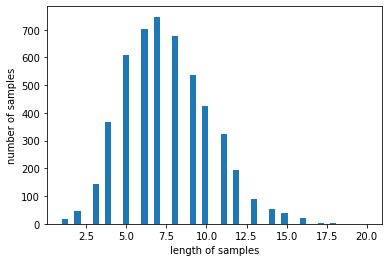

In [12]:
print('리뷰의 최대 길이 :',max(len(review) for review in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [13]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [14]:
max_len = 12
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 12 이하인 샘플의 비율: 95.7574544726836


In [15]:
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

In [16]:
embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=64, validation_split=0.2)

Epoch 1/15
63/63 [==============================] - ETA: 0s - loss: 0.5186 - acc: 0.7431
Epoch 00001: val_acc improved from -inf to 0.83300, saving model to best_model.h5
63/63 [==============================] - 6s 53ms/step - loss: 0.5186 - acc: 0.7431 - val_loss: 0.3781 - val_acc: 0.8330
Epoch 2/15
63/63 [==============================] - ETA: 0s - loss: 0.2682 - acc: 0.8919
Epoch 00002: val_acc did not improve from 0.83300
63/63 [==============================] - 2s 37ms/step - loss: 0.2682 - acc: 0.8919 - val_loss: 0.4838 - val_acc: 0.8270
Epoch 3/15
63/63 [==============================] - ETA: 0s - loss: 0.1947 - acc: 0.9239
Epoch 00003: val_acc improved from 0.83300 to 0.86100, saving model to best_model.h5
63/63 [==============================] - 3s 42ms/step - loss: 0.1947 - acc: 0.9239 - val_loss: 0.3332 - val_acc: 0.8610
Epoch 4/15
63/63 [==============================] - ETA: 0s - loss: 0.1462 - acc: 0.9415
Epoch 00004: val_acc did not improve from 0.86100
63/63 [==========

(array([1157.,  305.,  211.,  160.,  128.,  101.,   99.,  122.,   90.,
         105.,  102.,   94.,   82.,   92.,  100.,  119.,  143.,  177.,
         296., 1317.]),
 array([2.1375342e-06, 5.0001875e-02, 1.0000161e-01, 1.5000135e-01,
        2.0000109e-01, 2.5000083e-01, 3.0000058e-01, 3.5000029e-01,
        4.0000004e-01, 4.4999978e-01, 4.9999952e-01, 5.4999924e-01,
        5.9999901e-01, 6.4999872e-01, 6.9999850e-01, 7.4999821e-01,
        7.9999793e-01, 8.4999770e-01, 8.9999741e-01, 9.4999719e-01,
        9.9999690e-01], dtype=float32),
 <a list of 20 Patch objects>)

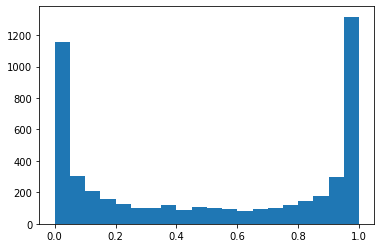

In [17]:
loaded_model = load_model('best_model.h5')
pred = loaded_model.predict(X_test)
plt.hist(pred, bins=20)

In [18]:
result = [0 if val < 0.5 else 1 for val in pred]
sub['label'] = result
sub.to_csv("baseline.csv", index=False) # 0.848